In [1]:
import numpy as np
import torch
import matplotlib.pyplot as pl
import seaborn as sns
import ot
import ot.plot
from matplotlib.lines import Line2D

In [3]:
import sys
sys.path.append('../../code/')
from generate_data import make_data_1d
from sinkhorn_iterates import sinkhorn
from sinkhorn_iterates_logdomain import logsinkhorn
from linear_solver import UOT_W, UOT_KL,UOT_l2
from generate_data import make_data

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


In [5]:
bl="#4A90E2"
o='#F5A623'
v="#7ED321"

In [6]:
def plot2D_samples_mat2(xs, xt, G, thr=1e-8, **kwargs):
    if ('color' not in kwargs) and ('c' not in kwargs):
        kwargs['color'] = 'k'
    mx = G.max()
    if 'alpha' in kwargs:
        scale = kwargs['alpha']
        del kwargs['alpha']
    else:
        scale = 1
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                pl.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=G[i, j]* scale, **kwargs)

# UOT is robust to outlier

In [36]:
n=60
X,Y=make_data("mog_reg",n,2)

X_out=X.clone()
Y_out=Y.clone()

X_out[0,:]=torch.tensor([-14,13])
X_out[36,:]=torch.tensor([10,11])
X_out[13,:]=torch.tensor([10,-11])
Y_out[0,:]=torch.tensor([-18,-7])
Y_out[38,:]=torch.tensor([-9,-16])

a,b=torch.ones((n,)),torch.ones((n,))
C=ot.dist(X_out,Y_out)
P=ot.emd(a,b,C)
                       
Puot=UOT_l2(a,b,C,lam=30)

W=torch.sum(C*P)
UOT=np.sum(Puot*C.numpy())
print(W,UOT)

tensor(1342.6890) 598.9605982645762


/tmp/ipykernel_7917/1443867542.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()
/home/gui/.local/lib/python3.10/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


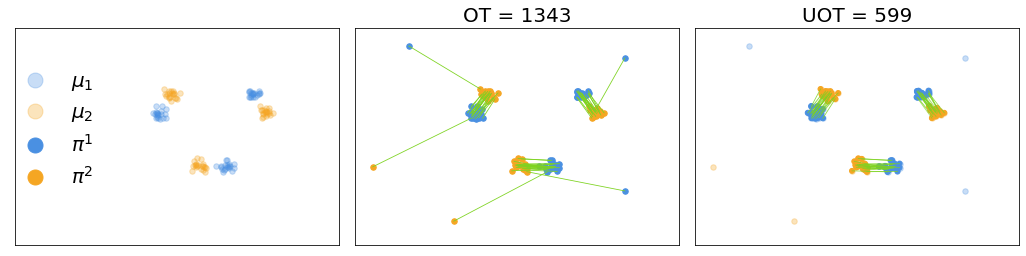

In [41]:
s=3e1
fig = pl.figure(figsize=(18,4))

grid = pl.GridSpec(1, 3, wspace=0.05, hspace=0)

ax=pl.subplot(grid[0,0])   
pl.scatter(X[:,0],X[:,1],c=bl,s=s,alpha=.3)
pl.scatter(Y[:,0],Y[:,1],c=o,s=s,alpha=.3)
pl.xlim(-25,16)
pl.ylim(-20,16)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])
label1 = Line2D([0], [0], label="$\mu_1$", marker='o', color=bl, linestyle='',markersize=15,alpha=.3)
label2 = Line2D([0], [0], label="$\mu_2$", marker='o', color=o, linestyle='',markersize=15,alpha=.3)
label3 = Line2D([0], [0], label="$\pi^1$", marker='o', color=bl, linestyle='',markersize=15)
label4 = Line2D([0], [0], label="$\pi^2$", marker='o', color=o, linestyle='',markersize=15)
handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2,label3,label4])   
pl.legend(frameon=False,bbox_to_anchor=(.3,.88),handles=handles, prop={'size': 20})

ax=pl.subplot(grid[0,1]) 
plot2D_samples_mat2(X_out,Y_out,P.numpy(), c=v,linewidth=.8)
pl.scatter(X_out[:,0],X_out[:,1],c=bl,s=s)
pl.scatter(Y_out[:,0],Y_out[:,1],c=o,s=s)
pl.title("OT = %1.0f"%W,size=20)#,x=.5,y=1.02)
pl.xlim(-20,16)
pl.ylim(-20,16)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])

ax=pl.subplot(grid[0,2]) 
plot2D_samples_mat2(X_out,Y_out,Puot, c=v,linewidth=.8)
pl.scatter(X_out[:,0],X_out[:,1],c=bl,s=s,alpha=0.3)
pl.scatter(Y_out[:,0],Y_out[:,1],c=o,s=s,alpha=0.3)
pl.scatter(X_out[:,0],X_out[:,1],c=bl,s=s*np.sum(Puot,1))
pl.scatter(Y_out[:,0],Y_out[:,1],c=o,s=s*np.sum(Puot,0))
pl.title("UOT = %1.0f"%UOT,size=20)#,x=.5,y=1.02)
pl.xlim(-20,16)
pl.ylim(-20,16)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])
pl.tight_layout()

pl.savefig("../../Figures/UOT/empirical_toy_clean.pdf",bbox_inches='tight')

# Not robust

In [76]:
from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox,OffsetImage

In [77]:
def mapData(dist_matrix, X, y, metric, title):
    mds = MDS(metric=metric, dissimilarity='precomputed', random_state=0)
    # Get the embeddings
    pts = mds.fit_transform(dist_matrix)
    # Plot the embedding, colored according to the class of the points
    fig = plt.figure(2, (15,6))
    ax = fig.add_subplot(1,2,1)    
    ax = sns.scatterplot(x=pts[:, 0], y=pts[:, 1],
                         hue=y, palette=['r', 'g', 'b', 'c'])

    # Add the second plot
    ax = fig.add_subplot(1,2,2)
    # Plot the points again
    plt.scatter(pts[:, 0], pts[:, 1])
    
    # Annotate each point by its corresponding face image
    for x, ind in zip(X, range(pts.shape[0])):
        im = x.reshape(64,64)
        imagebox = OffsetImage(im, zoom=0.3, cmap=plt.cm.gray)
        i = pts[ind, 0]
        j = pts[ind, 1]
        ab = AnnotationBbox(imagebox, (i, j), frameon=False)
        ax.add_artist(ab)
    plt.title(title)    
    plt.show()

In [84]:
cat=[]
galaxy=[]
for i in range(1,6):
    cat+=[io.imread("./data/Images/cats/"+str(i)+".jpg")]
for i in range(1,5):
    galaxy+=[io.imread("./data/Images/galaxy/"+str(i)+".jpg")]
galaxy+=[io.imread("./data/Images/dog/1.jpg")]
np.random.seed(2)
X,_=make_data("gaussians",5,2)
X=torch.tensor([-15,0])+3*X
Y,_=make_data("gaussians",5,2)
Y=torch.tensor([10,10])+6*Y
Y[-1]=torch.tensor([-22,-18])

C=ot.dist(X,Y)
a,b=torch.ones((5,)),torch.ones((5,))
P=ot.emd(a,b,C)

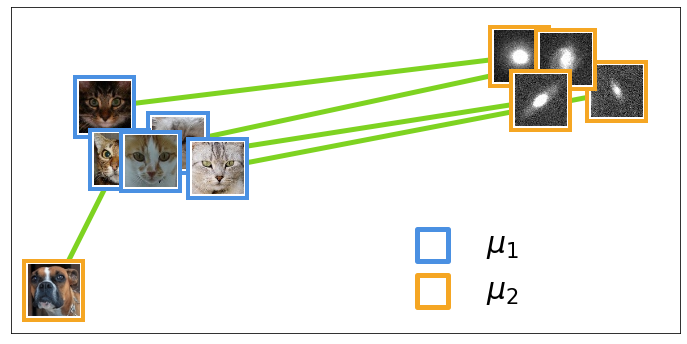

In [85]:
fig, ax = pl.subplots(figsize=(12,6))

plot2D_samples_mat2(X,Y,P.numpy(), c=v,linewidth=5)
for i in range(5):
    imagebox = OffsetImage(cat[i], zoom=.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, X[i],bboxprops=dict(edgecolor=bl,linewidth=4))
    ax.add_artist(ab)
    
    imagebox = OffsetImage(galaxy[i], zoom=.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox,Y[i],bboxprops=dict(edgecolor=o,linewidth=4))
    ax.add_artist(ab)

    
pl.scatter(X[:, 0], X[:, 1],marker="s", facecolors='none', edgecolors=bl,label="$\mu_1$",s=1e3,linewidth=5)
pl.scatter(Y[:, 0], Y[:, 1],marker="s", facecolors='none', edgecolors=o,label="$\mu_2$",s=1e3,linewidth=5)
# Fix the display limits to see everything
ax.set_xlim(-25, 22)
ax.set_ylim(-24, 22)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])

handles, labels = pl.gca().get_legend_handles_labels()
handles.extend([label1,label2])   
pl.legend(frameon=False,bbox_to_anchor=(.8, .4),prop={'size': 30})
pl.savefig("./Figures/UOT/Outlier_img_1.pdf",bbox_inches='tight')
pl.show()

In [86]:
C=ot.dist(X,Y)
a,b=torch.ones((5,)),torch.ones((5,))
Puot=UOT_l2(a,b,C,lam=4e2)
Puot*=1.5

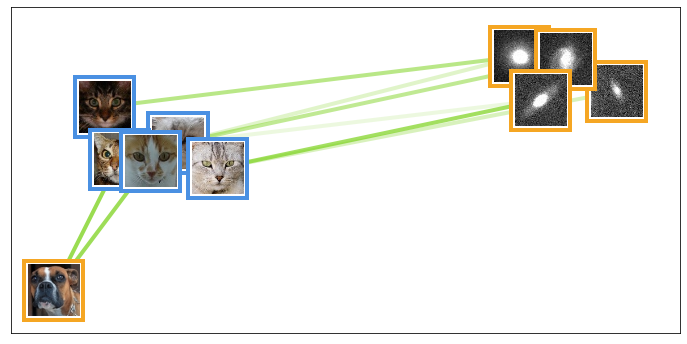

In [87]:
fig, ax = pl.subplots(figsize=(12,6))

plot2D_samples_mat2(X,Y,Puot, c=v,linewidth=4)
for i in range(5):
    imagebox = OffsetImage(cat[i], zoom=.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, X[i],bboxprops=dict(edgecolor=bl,linewidth=4))
    ax.add_artist(ab)
    
    imagebox = OffsetImage(galaxy[i], zoom=.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox,Y[i],bboxprops=dict(edgecolor=o,linewidth=4))
    ax.add_artist(ab)

# Fix the display limits to see everything
ax.set_xlim(-25, 22)
ax.set_ylim(-24, 22)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])
pl.savefig("./Figures/UOT/Outlier_img_2.pdf",bbox_inches='tight')
pl.show()

In [88]:
C=ot.dist(X,Y)
a,b=torch.ones((5,)),torch.ones((5,))
Puot=UOT_l2(a,b,C,lam=1.7e2)
Puot*=2

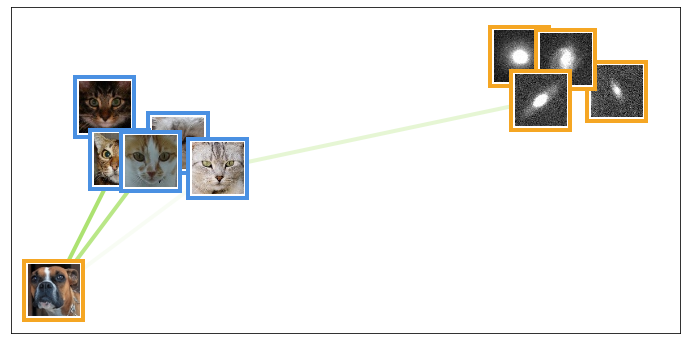

In [89]:
fig, ax = pl.subplots(figsize=(12,6))

plot2D_samples_mat2(X,Y,Puot, c=v,linewidth=4)
for i in range(5):
    imagebox = OffsetImage(cat[i], zoom=.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, X[i],bboxprops=dict(edgecolor=bl,linewidth=4))
    ax.add_artist(ab)
    
    imagebox = OffsetImage(galaxy[i], zoom=.8)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox,Y[i],bboxprops=dict(edgecolor=o,linewidth=4))
    ax.add_artist(ab)

# Fix the display limits to see everything
ax.set_xlim(-25, 22)
ax.set_ylim(-24, 22)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_xticklabels([])
pl.savefig("./Figures/UOT/Outlier_img_3.pdf",bbox_inches='tight')
pl.show()